In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
from statsmodels.tsa.seasonal import STL

In [2]:
data = pd.read_csv("times_series_data_no_labels.csv" ,
    index_col='datetime',
    parse_dates=['datetime']
    )

data = data.asfreq('5min')
data.describe()

,data_0,data_1
count,51840.000000,51840.000000
mean,27.428187,27.427566
std,4.276855,4.281787
min,16.042714,16.342305
25%,23.792250,23.832418
50%,29.712173,29.709107
75%,30.188862,30.189345
max,41.066048,41.122645


In [3]:
data

,data_0,data_1
datetime,,
2023-01-01 00:00:00,21.719925,19.925141
2023-01-01 00:05:00,21.357656,19.671888
2023-01-01 00:10:00,20.178934,19.543689
2023-01-01 00:15:00,19.197688,18.872886
2023-01-01 00:20:00,20.098658,19.599005
...,...,...
2023-06-29 23:35:00,19.636588,20.640584
2023-06-29 23:40:00,20.692796,19.895390
2023-06-29 23:45:00,20.081966,20.584634


In [4]:
data['data_0']

datetime
2023-01-01 00:00:00    21.719925
2023-01-01 00:05:00    21.357656
2023-01-01 00:10:00    20.178934
2023-01-01 00:15:00    19.197688
2023-01-01 00:20:00    20.098658
                         ...    
2023-06-29 23:35:00    19.636588
2023-06-29 23:40:00    20.692796
2023-06-29 23:45:00    20.081966
2023-06-29 23:50:00    19.956621
2023-06-29 23:55:00    19.974779
Freq: 5min, Name: data_0, Length: 51840, dtype: float64

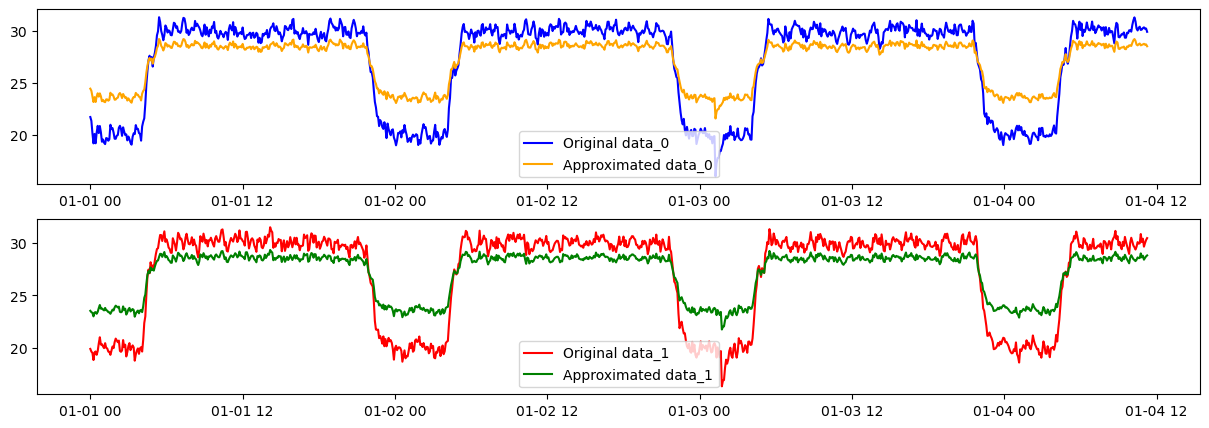

In [5]:
def fourier_series_decomposition(data, n_terms):
    N = len(data)
    t = np.arange(0, N)
    f = fft(data)
    
    reconstructed_signal = np.zeros(N)
    for k in range(n_terms):
        amplitude = np.abs(f[k]) / N
        phase = np.angle(f[k])
        reconstructed_signal += amplitude * np.cos(2 * np.pi * k * t / N + phase)
    
    return reconstructed_signal

# Apply the Fourier series decomposition
n_terms = 500  # Number of terms in the Fourier series
data = data.head(1000)
data_0_approx = fourier_series_decomposition(data['data_0'].values, n_terms)
data_1_approx = fourier_series_decomposition(data['data_1'].values, n_terms)


# Plot the original data and the approximated data
plt.figure(figsize=(15, 5))
plt.subplot(2, 1, 1)
plt.plot(data.index, data['data_0'], label='Original data_0', color='blue')
plt.plot(data.index, data_0_approx, label='Approximated data_0', color='orange')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(data.index, data['data_1'], label='Original data_1', color='red')
plt.plot(data.index, data_1_approx, label='Approximated data_1', color='green')
plt.legend()
plt.show()

In [6]:
data

,data_0,data_1
datetime,,
2023-01-01 00:00:00,21.719925,19.925141
2023-01-01 00:05:00,21.357656,19.671888
2023-01-01 00:10:00,20.178934,19.543689
2023-01-01 00:15:00,19.197688,18.872886
2023-01-01 00:20:00,20.098658,19.599005
...,...,...
2023-01-04 10:55:00,30.233418,30.374725
2023-01-04 11:00:00,30.305561,29.620004
2023-01-04 11:05:00,30.169918,29.959005


In [7]:

# # Resample data to monthly frequency
# data_monthly = data.resample('M').mean()

# # Plot for each month separately
# n_terms = 500  # Number of terms in the Fourier series

# for month_start in data_monthly.index:
#     # Slice the original dataframe for the month
#     month_data = data[(data.index >= month_start) & (data.index < month_start + pd.DateOffset(months=1))]
    
#     if not month_data.empty:
#         data_0_approx = fourier_series_decomposition(month_data['data_0'].values, n_terms)
#         data_1_approx = fourier_series_decomposition(month_data['data_1'].values, n_terms)
        
#         plt.figure(figsize=(15, 10))
#         plt.subplot(2, 1, 1)
#         plt.plot(month_data.index, month_data['data_0'], label='Original data_0', color='blue')
#         plt.plot(month_data.index, data_0_approx, label='Approximated data_0', color='orange')
#         plt.title(f'Data for {month_start.strftime("%Y-%m")}')
#         plt.legend()
        
#         plt.subplot(2, 1, 2)
#         plt.plot(month_data.index, month_data['data_1'], label='Original data_1', color='red')
#         plt.plot(month_data.index, data_1_approx, label='Approximated data_1', color='green')
#         plt.legend()
        
#         plt.show()

In [9]:
from prophet import Prophet
import plotly.graph_objects as go
import plotly.express as px

train_size = int(0.8 * len(data))
train_df = data.iloc[:train_size].copy()
test_df = data.iloc[train_size:].copy()

# Prepare the training data for Prophet
train_df.reset_index(inplace=True)
train_df.rename(columns={'datetime': 'ds', 'data_0': 'y'}, inplace=True)

# Initialize and fit the Prophet model with additional parameters
model = Prophet(daily_seasonality=True, weekly_seasonality=False)
model.fit(train_df[['ds', 'y']])

# Make a dataframe for future predictions
future = model.make_future_dataframe(periods=len(test_df), freq='5min')

# Predict
forecast = model.predict(future)

# Plot the forecast using Plotly
fig = px.line(forecast, x='ds', y=['yhat', 'yhat_lower', 'yhat_upper'], title='Forecast with Prophet')
fig.add_scatter(x=train_df['ds'], y=train_df['y'], mode='lines', name='Training Data')
fig.add_scatter(x=test_df.index, y=test_df['data_0'], mode='lines', name='Actual Data')
fig.show()

# Plot the components using Plotly
# components = model.plot_components(forecast)

# # Extracting components
# trend = forecast[['ds', 'trend']]
# weekly = forecast[['ds', 'weekly']]
# daily = forecast[['ds', 'daily']]

# # Plotting trend component
# fig_trend = px.line(trend, x='ds', y='trend', title='Trend Component')
# fig_trend.show()

# # Plotting weekly component
# fig_weekly = px.line(weekly, x='ds', y='weekly', title='Weekly Component')
# fig_weekly.show()

# # Plotting daily component
# fig_daily = px.line(daily, x='ds', y='daily', title='Daily Component')
# fig_daily.show()

00:37:33 - cmdstanpy - INFO - Chain [1] start processing
00:37:33 - cmdstanpy - INFO - Chain [1] done processing
